In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load Dataset extracted from BigQuery
file_path = "/home/nsmsc/merged_instance_usage_200k - new.csv"
data = pd.read_csv(file_path)

# Convert start and end times from microseconds to seconds
data['start_time'] = data['start_time'] / 1e6
data['end_time'] = data['end_time'] / 1e6

# Sort data by start time
data = data.sort_values(by='start_time')

# Define the interval length 
interval_length = 300

def process_interval(interval_data):
    collection_id_counts = interval_data['collection_id'].value_counts()
    non_unique_collection_ids_count = collection_id_counts[collection_id_counts > 1].count()
    unique_collection_ids_count = interval_data['collection_id'].nunique()
    unique_machine_ids_count = interval_data['machine_id'].nunique()
    sum_avg_cpu = interval_data['average_usage.cpus'].sum()
    sum_avg_memory = interval_data['average_usage.memory'].sum()
    sum_max_cpu = interval_data['maximum_usage.cpus'].sum()
    sum_max_memory = interval_data['maximum_usage.memory'].sum()
    return {
        'unique_collection_ids': unique_collection_ids_count,
        'non_unique_collection_ids': non_unique_collection_ids_count,
        'unique_machine_ids': unique_machine_ids_count,
        'sum_avg_cpu': sum_avg_cpu,
        'sum_avg_memory': sum_avg_memory,
        'sum_max_cpu': sum_max_cpu,
        'sum_max_memory': sum_max_memory
    }

def prepare_features(data):
    results = []
    start_time = data['start_time'].min()
    end_time = data['start_time'].max()
    current_start = start_time

    while current_start < end_time:
        current_end = current_start + interval_length
        interval_data = data[(data['start_time'] >= current_start) & (data['start_time'] < current_end)]
        if not interval_data.empty:
            interval_result = process_interval(interval_data)
            interval_result['interval_start'] = current_start
            results.append(interval_result)
        current_start = current_end

    df = pd.DataFrame(results)

    # Add time-based features
    df['hour_of_day'] = (df['interval_start'] % 86400) // 3600
    df['day_of_week'] = (df['interval_start'] // 86400) % 7

    # Add lag features
    lag_features = ['unique_collection_ids', 'non_unique_collection_ids', 'unique_machine_ids', 'sum_avg_cpu', 'sum_avg_memory', 'sum_max_cpu', 'sum_max_memory']
    for feature in lag_features:
        for lag in range(1, 4):
            df[f'{feature}_lag{lag}'] = df[feature].shift(lag)
    
    # Add rolling statistics
    for feature in lag_features:
        df[f'{feature}_rolling_mean'] = df[feature].rolling(window=3).mean()
        df[f'{feature}_rolling_std'] = df[feature].rolling(window=3).std()

    # Drop rows with NaN values created by shifting
    df = df.dropna().reset_index(drop=True)
    
    return df

# Split the data into 70% training and 30% testing
train_data, test_data = train_test_split(data, test_size=0.3, shuffle=False)


train_features = prepare_features(train_data)


test_features = prepare_features(test_data)

X_train = train_features.drop(columns=['unique_collection_ids', 'non_unique_collection_ids', 'unique_machine_ids', 'interval_start'])
y_train = train_features[['unique_collection_ids', 'non_unique_collection_ids', 'unique_machine_ids']]

# Initialize XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')

# Train the model
model.fit(X_train, y_train)


X_test = test_features.drop(columns=['unique_collection_ids', 'non_unique_collection_ids', 'unique_machine_ids', 'interval_start'])
y_test = test_features[['unique_collection_ids', 'non_unique_collection_ids', 'unique_machine_ids']]


y_pred = model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

pred_df = pd.DataFrame(y_pred, columns=['unique_collection_ids_pred', 'non_unique_collection_ids_pred', 'unique_machine_ids_pred'])
result_df = pd.concat([test_features.reset_index(drop=True), pred_df], axis=1)
print(result_df.head())


/home/nsmsc/.local/lib/python3.8/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


Mean Squared Error: 0.5828954268707407
   unique_collection_ids  non_unique_collection_ids  unique_machine_ids  \
0                     12                          0                  12   
1                     20                          2                  22   
2                     16                          0                  16   
3                     19                          3                  22   
4                     14                          1                  15   

   sum_avg_cpu  sum_avg_memory  sum_max_cpu  sum_max_memory  interval_start  \
0     0.042142        0.040916     0.194399        0.044452       1884900.0   
1     0.054090        0.082142     0.292039        0.087450       1885200.0   
2     0.194715        0.091646     0.664663        0.099927       1885500.0   
3     0.077525        0.058698     0.297894        0.065578       1885800.0   
4     0.094784        0.068568     0.292549        0.080093       1886100.0   

   hour_of_day  day_of_week  ...  s

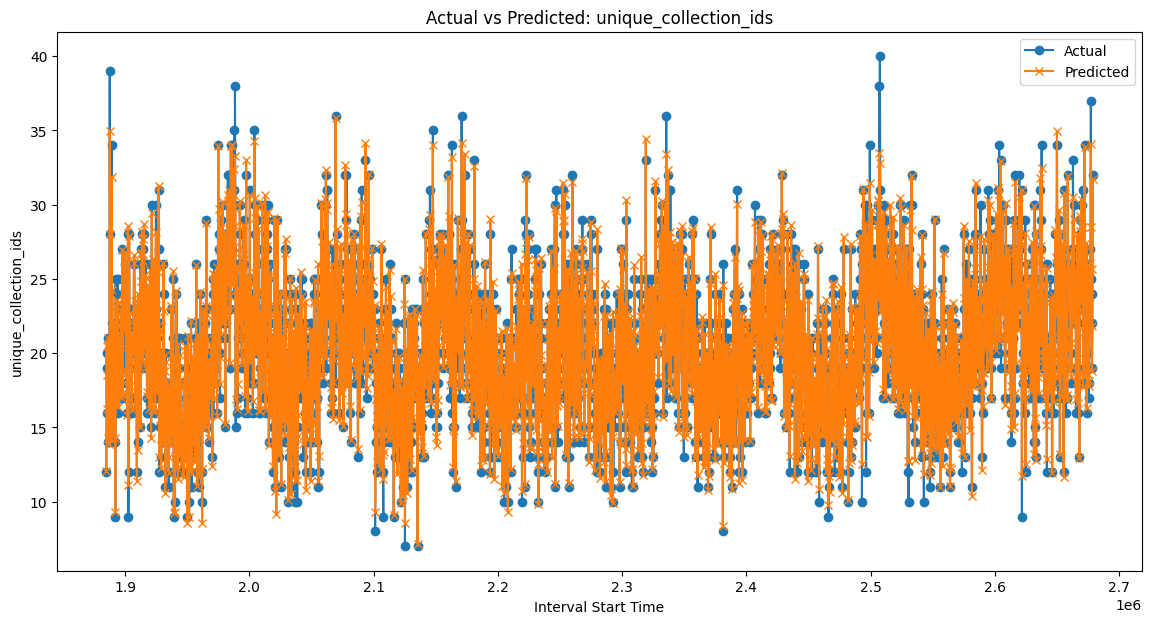

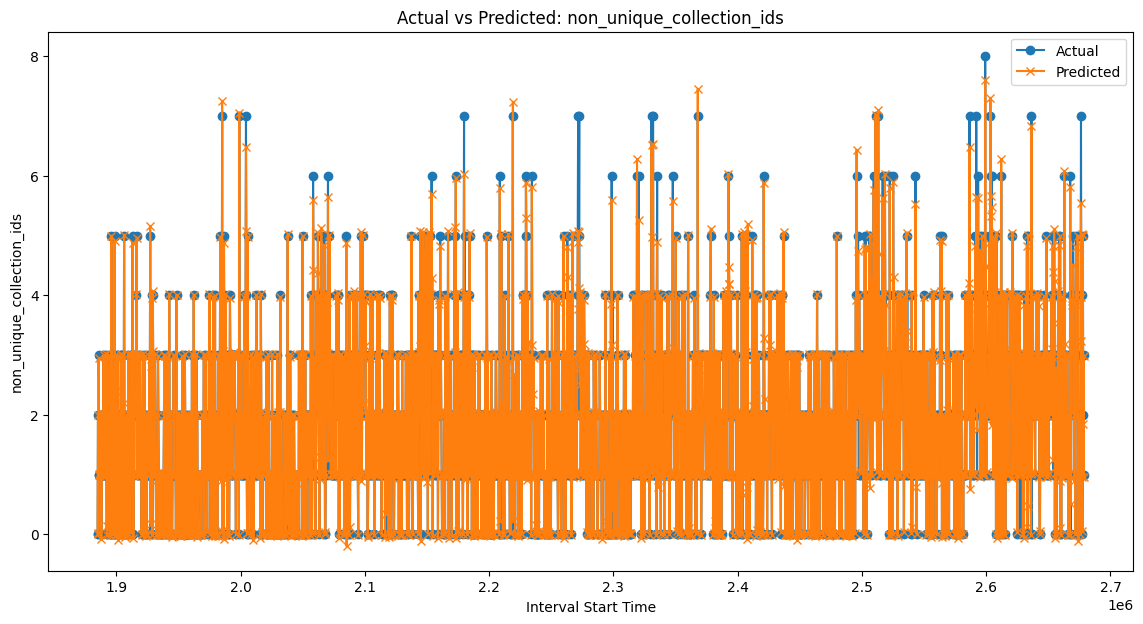

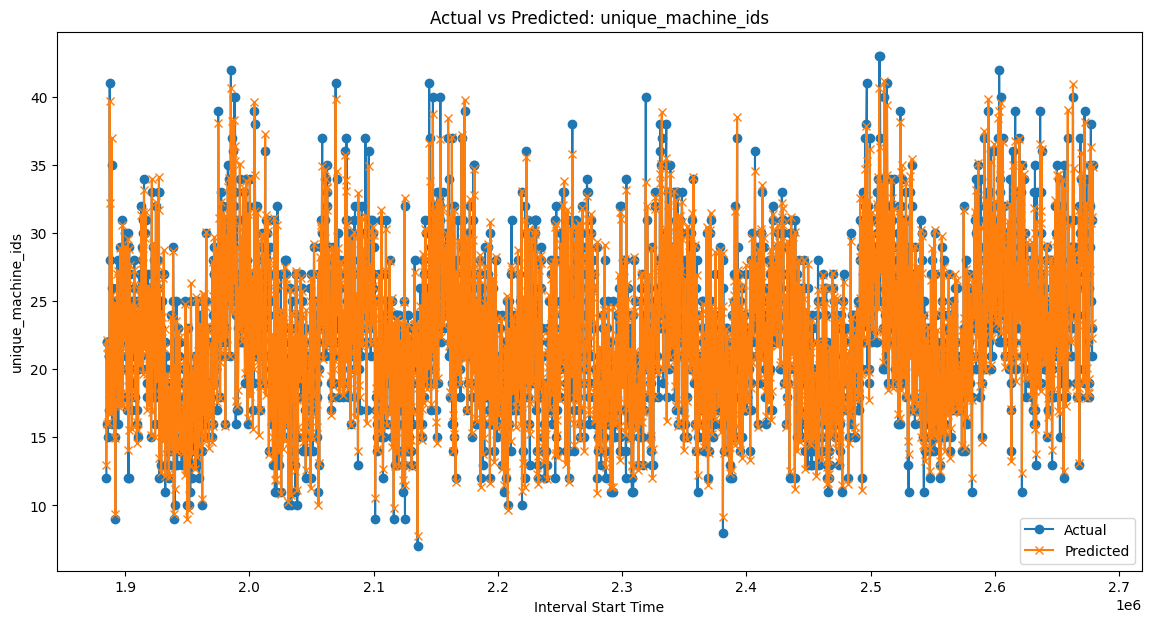

In [2]:
import matplotlib.pyplot as plt


def plot_actual_vs_predicted(result_df, actual_col, predicted_col, interval_col):
    plt.figure(figsize=(14, 7))
    plt.plot(result_df[interval_col], result_df[actual_col], label='Actual', marker='o')
    plt.plot(result_df[interval_col], result_df[predicted_col], label='Predicted', marker='x')
    plt.title(f'Actual vs Predicted: {actual_col}')
    plt.xlabel('Interval Start Time')
    plt.ylabel(actual_col)
    plt.legend()
    plt.show()


plot_actual_vs_predicted(result_df, 'unique_collection_ids', 'unique_collection_ids_pred', 'interval_start')
plot_actual_vs_predicted(result_df, 'non_unique_collection_ids', 'non_unique_collection_ids_pred', 'interval_start')
plot_actual_vs_predicted(result_df, 'unique_machine_ids', 'unique_machine_ids_pred', 'interval_start')


In [3]:
from sklearn.metrics import mean_absolute_error


def calculate_metrics(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
    mae = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test - y_pred) / y_test), axis=0) * 100

    return mse, mae, rmse, mape


y_pred = model.predict(X_test)


mse, mae, rmse, mape = calculate_metrics(y_test, y_pred)


target_columns = ['unique_collection_ids', 'non_unique_collection_ids', 'unique_machine_ids']
for i, target in enumerate(target_columns):
    print(f"{target}:\n MSE: {mse[i]}\n MAE: {mae[i]}\n RMSE: {rmse[i]}\n MAPE: {mape[i]}%\n")



unique_collection_ids:
 MSE: 0.6598625115430404
 MAE: 0.5722285509559853
 RMSE: 0.8123192177605061
 MAPE: 2.954525667269237%

non_unique_collection_ids:
 MSE: 0.023453273986870152
 MAE: 0.048603643445669004
 RMSE: 0.1531446178841103
 MAPE: inf%

unique_machine_ids:
 MSE: 1.0653704950823115
 MAE: 0.7132708222000473
 RMSE: 1.0321678618724337
 MAPE: 3.3149586834285047%

